_______________________________________

# **Tanzania Ministry of Water** - Water Well Functionality  
### Flatiron School Phase 3 Project  
Analysis by Jun (Andrew) Choi, Dara Estrada, Nicholas Wertz

---
## Table of Contents

1. [Business Understanding](#1.-Business-Understanding)
2. [Data Understanding](#2.-Data-Understanding)
3. [Data Preparation and EDA](#3.-Data-Preparation-and-EDA)   
4. [Modeling](#4.-Modeling)   
5. [Evaluation](#5.-Evaluation)
6. [Appendix](#6.-Appendix)

---
# 1. Business Understanding
---

There are two facts about Tanzania we want the reader to know before continuing.
<br /> 
####  Three out of ten people do not have access to basic drinking water. Four million people lack access to an improved source of safe water.   
  [[1]] [[2]].    
<br /> 
The Tanzania Ministry of Water has tasked our team with identifying which wells have a proclivity to be functional, while also identifying which wells are in need of repair. All of this will be achieved through predictive modeling from basic information we acquired about each well. 
  
The process for a Tanzanian to procure water is very different compared to those of us who reside in a developed nation. Only 3% of homes in this East African country have an access point within their home while 81% of people are required to travel outside of their village or compound to reach a water well [[3]]. 

Our data scientist, Andrew, lived in Tanzania for over a year and shared that during his participation during an excursion on water collecting where simply accessing the well took a 45 minute walk. This highlights the need for the Ministry of Water to be able to anticipate which wells are in need of service and thus allow a chance to be proactive with repairs.

Due to the risk of dehydration it's imperative to ensure that the wells communities depend on remain in service. Failing to find the best models or a high rate of error would directly affect citizens' ability to receive the water needed for survival. As our binary target was split into wells needing repair (0) and functional wells (1), a false positive would mean marking a well as functioning when it is not. Every false positive means a community is not labeled as in need of aid. This can lead to a community to take drastic measures such as relocating to regain reliable access to water or risk dying of thirst. It can also waste valuable resouces that could be used on non-functional wells. Because of these risks we decided that precision as our evaluation metric was of the most importance.

[1]: <https://data.worldbank.org/indicator/SP.RUR.TOTL.ZS?locations=TZ/> "[1]"
[2]: <https://www.statista.com/statistics/1266634/access-to-drinking-water-in-tanzania-by-residence/> "[2]"
[3]: <https://www.washingtonpost.com/politics/2020/03/22/millions-africans-lack-access-clean-water-this-makes-coronavirus-bigger-threat/> "[3]"


---
# 2. Data Understanding
---

Our team obtained data sets from DrivenData who collected data from the Tanzania Ministry of Water and Taarifa, a Rwandan news provider, in addition to conducting some initial data cleaning.  
This initial data included a training data set which contained each of these wells' functional status.
The data was limited by date from 2011 - 2013 and also had some unuseable data points. The `private_num` was unspecificed as to what it was and `population` also had a lot of 0's which we could not identify as null, erroneously data or if it was truly 0.

## Importing the packages/libraries and our datasets

In [1]:
# Import required packages
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
import geopandas as gpd     
import contextily as cx    

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, accuracy_score, log_loss, make_scorer


In [2]:
# Importing CSV's
df_test = pd.read_csv('data/test_set_values.csv')
df_train = pd.read_csv('data/training_set_values.csv')
df_train_label = pd.read_csv('data/training_set_labels.csv')

After reviewing the inital data we found a total of 41 columns and that our target had already been parsed out for us.
We found that only 32,259 water wells out of a total of 59,400 in the country have been recorded as functional and set to work deciphering which columns could be eliminated to gain a clearer picture of what we were working with.

In [3]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14850 non-null  int64  
 1   amount_tsh             14850 non-null  float64
 2   date_recorded          14850 non-null  object 
 3   funder                 13981 non-null  object 
 4   gps_height             14850 non-null  int64  
 5   installer              13973 non-null  object 
 6   longitude              14850 non-null  float64
 7   latitude               14850 non-null  float64
 8   wpt_name               14850 non-null  object 
 9   num_private            14850 non-null  int64  
 10  basin                  14850 non-null  object 
 11  subvillage             14751 non-null  object 
 12  region                 14850 non-null  object 
 13  region_code            14850 non-null  int64  
 14  district_code          14850 non-null  int64  
 15  lg

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [5]:
df_train_label.columns

Index(['id', 'status_group'], dtype='object')

---
# 3. Data Preparation and EDA
---


We continued with additional cleaning ourselves, changing the three initial well status targets into a binary target of wells that are completely functional and wells in need of repair. This weighs wells that are completely broken equally with wells that are technically functional, but are unreliable or have contaminated water due malfunction. 

In [6]:
# Reassigning targets to establish bionomial targets
target = df_train_label.replace({'status_group': {'functional' : 1, 
                                'non functional' : 0, 
                                'functional needs repair' : 0}})
df = pd.concat([df_train, target], axis = 1)

In [7]:
# Getting the number of wells that are functional and those that are not
print(df['status_group'].value_counts())

1    32259
0    27141
Name: status_group, dtype: int64


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [9]:
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,id,status_group
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475,37115.131768,0.543081
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547,21453.128371,0.498145
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000,18519.750000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000,37061.500000,1.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000,55656.500000,1.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000,74247.000000,1.000000


## Eliminating features that we found to be redudant or unuseable for our models. 

Many of the features had the same information provided by similar features in the dataset so we trimmed them. In addition to this some features like `'num_private'` had no feature descriptions explaining what it was so we chose to not utilize it.

In [10]:
# Removing columns that are non-factors for our model
col_to_delete = ['id', 'recorded_by', 'funder', 'public_meeting',
                'lga', 'ward', 'region_code', 'district_code', 
                 'wpt_name','scheme_name', 'extraction_type', 'extraction_type_group',
                 'payment', 'quality_group', 'source_type', 'quantity_group',
                 'waterpoint_type_group', 'subvillage', 'num_private']

We created a new feature `'year_recorded'` to capture only the year that the data was recorded to transform the `'date_recorded'`. This was because we believed that this may have been important to keep in our data, but keeping it in its original state may have cause our model to be too complex with the sheer number of unique values.

We applied the same thought processes to the following features. In addition we dropped any data that was entered before 2005 as it only comprised 0.06% of our data and created additional problems when attempting to train test split our data.

In [11]:
def data_cleaning(df_to_clean):
    # Removing columns that are non-factors for our model
    col_to_delete = ['id', 'recorded_by', 'funder', 'public_meeting',
                'lga', 'ward', 'region_code', 'district_code', 
                 'wpt_name','scheme_name', 'extraction_type', 'extraction_type_group',
                 'payment', 'quality_group', 'source_type', 'quantity_group',
                 'waterpoint_type_group', 'subvillage', 'num_private']
    
    # Remove duplicated data entries and null values
    dfn = df_to_clean.drop(col_to_delete, axis = 1)
    dfn = dfn.dropna(axis = 0) 
    
    # Pulling the year off and type casting to int
    dfn['year_recorded'] = [int(val[0:4]) for val in dfn['date_recorded']]
    dfn['year_recorded'].astype(np.int64)
    dfn.drop(['date_recorded'], axis = 'columns', inplace = True)
    
    # Binning the years into decades
    dfn['construction_year'] = ['unknown' if val == 0 
                           else str((val // 10) * 10) for val in dfn['construction_year']]
    
    # Binning the unique values
    scheme_management_list = ['SWC', 'Trust', 'None']
    dfn['scheme_management'].replace(scheme_management_list, 'Other', inplace = True)
    
    # Binning unique values
    installer_list = ['DWE', 'Government', 'Commu', 'DANIDA', 
                  'RWE', 'KKKT', 'TCRS']
    dfn['installer'] = ['Other' if val not in installer_list 
                           else val for val in dfn['installer']]

    dfn.drop(dfn.index[dfn['year_recorded'] < 2005], inplace=True)
    dfn.reset_index(inplace=True, drop=True)
    return dfn

---
# 4. Modeling
---


The cleaned training data was combined with the target data and split into a 75% train/25% testing set for us to train and evaluate the effectiveness of our models before we attempted to use them on our true testing data, a similar list of wells with no functional status provided.

We also designed functions for :
- One Hot Encoding and Scaling our data
- Creating a dataframe with scaled numerics and one hot encoded categoricals
- Printing the accuracy, precision score as well as a confusion matrix for the model

In [12]:
def num_encoder(df_to_encode):
    ss = StandardScaler()

    ss.fit(df_to_encode)
    nums_df = pd.DataFrame(ss.transform(df_to_encode),
                           columns = df_to_encode.columns,
                          index = df_to_encode.index)
    return nums_df

def cat_encoder(df_to_encode):
    ohe = OneHotEncoder(
        drop = 'first',
        sparse = False)
    
    dums = ohe.fit_transform(df_to_encode)
    dums_df = pd.DataFrame(dums,
                            columns = ohe.get_feature_names(),
                            index = df_to_encode.index)
    return dums_df

In [13]:
def split_join(split):
    categories = split.select_dtypes('object')
    numerics = split.select_dtypes(['float64', 'int64'])

    joined = pd.concat([num_encoder(numerics), cat_encoder(categories)], axis = 1)
    return joined

In [14]:
def score_maxtrix_printer(model, X_train, y_train, X_test, y_test):
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    ascore_train = accuracy_score(y_train, train_pred)
    pscore_train = precision_score(y_train, train_pred)
    
    ascore_test = accuracy_score(y_test, test_pred)
    pscore_test = precision_score(y_test, test_pred)
    
    conf_mat = plot_confusion_matrix(model, X_test, y_test)
    
    print(f"""
    Train Accuracy: {ascore_train}
    Train Precision: {pscore_train}
    Test Accuracy: {ascore_test}
    Test Precision: {pscore_test}
    """)


---
## Establishing the Baseline (Dummy) Model

In [15]:
df2 = data_cleaning(df)

In [16]:
y = df2.status_group
X = df2.drop('status_group', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25, random_state = 69)

In [17]:
X_train_cat = X_train.select_dtypes('object')
X_train_nums = X_train.select_dtypes(['float64', 'int64'])

cont_pipeline = Pipeline(steps=[
    ('ss', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop = 'first'))
])

trans = ColumnTransformer(transformers=[
    ('continuous', cont_pipeline, X_train_nums.columns),
    ('categorical', cat_pipeline, X_train_cat.columns)
])

dummy = Pipeline(steps=[
    ('trans', trans),
    ('dummy', DummyClassifier(random_state = 69, strategy = 'most_frequent'))
])

#Fitting and checking the score
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.546180041072032

Our dummy model predictably produces a score of 54% because it is based on the majority target. This establishes our baseline.

---
## Model 1 (Decision Tree Classifier)

We decided to use a decision tree as our first model for feature selection. For the first iteration we did not specify any parameters except for the random state.

In [18]:
X_train_clean = split_join(X_train)
X_test_clean = split_join(X_test)


    Train Accuracy: 0.9955028724427462
    Train Precision: 0.996568487274807
    Test Accuracy: 0.7287117903930131
    Test Precision: 0.7751388032078964
    


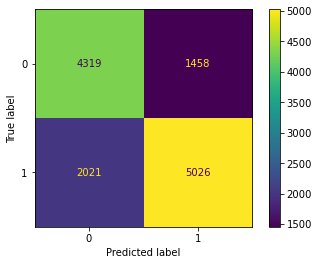

In [19]:
decision_tree = DecisionTreeClassifier(random_state = 69)
decision_tree.fit(X_train_clean, y_train)

score_maxtrix_printer(decision_tree, X_train_clean, y_train, X_test_clean, y_test)

Unsurprisingly the model is severly overfit with an accuracy score of 99% and precision score of 99% on the training set in comparison to the accuracy score of 70% and precision score of 74% on our testing set.

---
## Grid Search for Model 2 Optimal Parameters

We utilized Grid Search to find the optimal parameters for our Decision Tree model. This was done to solve the overfitting that was present in the previous iteration.

In [20]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_clean, y_train)

DecisionTreeClassifier()

In [21]:
param_dict = {
    "criterion":['gini', 'entropy'],
    "max_depth":[1, 10, 25, 50],
    "min_samples_split":range(1, 10),
    "min_samples_leaf":range(1, 10)
}

In [22]:
tw = GridSearchCV(estimator=decision_tree,
                 param_grid=param_dict,
                 cv=5,
                 verbose=1,
                 n_jobs=-1)
tw.fit(X_train_clean, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 1186 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 2386 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  1.8min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 10, 25, 50],
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(1, 10)},
             verbose=1)

In [23]:
print(tw.best_params_)
print(tw.best_estimator_)
print(tw.best_score_)

{'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2}
DecisionTreeClassifier(max_depth=25)
0.7830199901192672


Here we found that the best parameters for our Decision Tree model are <br>`criterion = 'gini', max_depth = 25, min_samples_leaf = 7`

Kept getting different `min_samples_split` value without results changing so it seems `criterion`, `max_depth`, & and `min_samples_leaf` give us a consistent enough result that `min_samples_split` does not need to be manipulated by us.

---
## Model 2 (Decision Tree) with Optimized Parameters

Now that we have our optimal parameters we are building the second model utilizing those parameters.


    Train Accuracy: 0.8749382619771764
    Train Precision: 0.8799249530956847
    Test Accuracy: 0.7585776668746101
    Test Precision: 0.7886891714160456
    


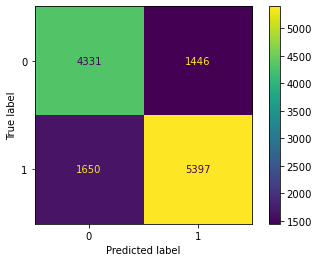

In [24]:
decision_tree_better = DecisionTreeClassifier(random_state = 69, criterion = 'gini', 
                                              max_depth = 25, min_samples_leaf = 7)
decision_tree_better.fit(X_train_clean, y_train)

score_maxtrix_printer(decision_tree_better, X_train_clean, y_train, X_test_clean, y_test)

With our optimized parameters, this decision tree performed much better than our first attempt, with new training  accuracy and precion scores of nearly 88% and a test accuracy and precion scores of 74%. The problem with our overfitted first model has now been resolved!

---
## Feature Importance & Model 3 (Logistic Regression) Using Top Predictors

Next, we used the `ExtraTreesClassifier()` to identify the features with the highest importance.

[1.51204592e-02 7.06406628e-02 1.37340982e-01 1.36315492e-01
 4.72249838e-02 1.04585835e-02 1.45451202e-03 9.94557097e-03
 5.61843325e-03 7.56059779e-04 1.13112511e-02 2.92588766e-03
 1.25030169e-03 5.41114638e-03 3.41190301e-03 4.68883007e-03
 4.92675089e-03 6.02937018e-03 4.51017425e-03 4.33482762e-03
 4.61324262e-03 8.02649401e-04 2.60340375e-03 9.57640338e-03
 2.51567977e-03 2.88325884e-03 3.51984141e-03 1.68975925e-03
 2.86243275e-03 2.11183814e-03 2.85066420e-03 2.24868608e-03
 2.01798762e-03 2.71378105e-03 2.95202009e-03 2.21810138e-03
 2.10763313e-03 2.46867841e-03 1.60774709e-03 1.72674229e-03
 2.85500754e-03 1.26153048e-03 1.37590369e-03 1.33682466e-03
 6.95967454e-03 1.97483717e-03 2.76806772e-03 4.29403628e-03
 3.72304589e-03 1.40076437e-02 9.86831249e-03 6.92186447e-03
 7.09766499e-03 1.22070393e-02 1.16489328e-02 6.07400735e-03
 9.57869640e-03 4.09645591e-03 2.69457505e-02 8.03834015e-04
 7.73753281e-03 5.22211378e-04 7.79239076e-04 2.08323776e-04
 1.35984258e-03 2.794983

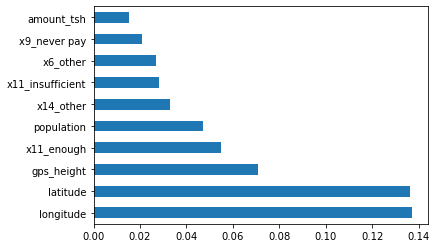

In [25]:
model = ExtraTreesClassifier()
model.fit(X_train_clean, y_train)

print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index = X_train_clean.columns)
feat_importances.nlargest(10).plot(kind = 'barh')
plt.show()

In [26]:
# gathering top features together
importance_col = ['longitude', 'latitude', 'gps_height', 'quantity', 
                  'status_group', 'population', 'waterpoint_type', 
                 'extraction_type_class', 'payment_type', 'amount_tsh']
df_importance = df2[importance_col]

---
 As expected the location of the well is significant. This is shown by the `latitude` `longitude` and `gps_height` being the three highest ranked features.
 We then used our top 10 most important features to predict our model using logistic regression.

In [27]:
y_Ext = df_importance.status_group
X_Ext = df_importance.drop('status_group', axis = 1)

X_train_Ext, X_test_Ext, y_train_Ext, y_test_Ext = train_test_split(X_Ext, y_Ext, 
                                                        test_size = 0.25, random_state = 69)

In [28]:
X_train_clean_Ext = split_join(X_train_Ext)
X_test_clean_Ext = split_join(X_test_Ext)


    Train Accuracy: 0.7301983415217448
    Train Precision: 0.6905649555491826
    Test Accuracy: 0.7339363693075484
    Test Precision: 0.6994841400504884
    


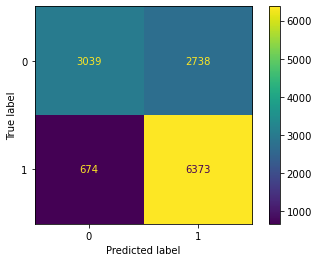

In [29]:
logreg_clf_Ext = LogisticRegression(random_state = 69, max_iter = 1000)
logreg_model_Ext = logreg_clf_Ext.fit(X_train_clean_Ext, y_train_Ext)

score_maxtrix_printer(logreg_model_Ext, X_train_clean_Ext, y_train_Ext, X_test_clean_Ext, y_test_Ext)

We recorded that the top 10 predictors we recived from our `ExtraTreesClassifier()` had a 73% accuracy score and 69% precision score of our test data when using a `LogisticRegression()`. This was with only 10 variables which shows how significant they are, however we can see that using just these yieled lower scores than our decision tree model.

---
## Model 4 (Logistic Regression) Utilizing All Predictors

Next, we ran a new Logistic Regression model which utilized all predictor columns available.
We decided to make a logistic regression model next to see how the accuracy and precision would compare with our decision tree model.


    Train Accuracy: 0.760846395799215
    Train Precision: 0.7430346927857113
    Test Accuracy: 0.7614628820960698
    Test Precision: 0.7472718253968254
    


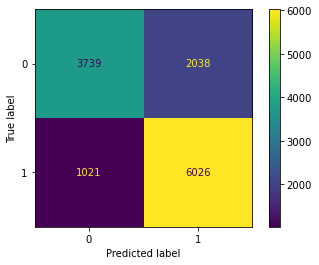

In [30]:
# All predictors were utilized in this model
logreg_clf = LogisticRegression(random_state = 69, max_iter = 1000)
logreg_model = logreg_clf.fit(X_train_clean, y_train)

score_maxtrix_printer(logreg_model, X_train_clean, y_train, X_test_clean, y_test)

With all predictors, both our training and testing sets' metrics improved. Test Accuracy had gone up to 76% and precision is slightly lower at 74%.


---
## Grid Search for Model 5 Optimal Parameters

For our final individual model, we again utilized Grid Search to find the optimal parameters for a kNN model. We too wanted to compare this model to see how the score would change from our decision tree as well as our logistic regression model.


In [31]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_clean, y_train)
grid = {
    'n_neighbors': range(1, 15),
    'metric': ['manhattan', 'minkowski'],
    'weights' : ['distance', 'uniform']
}

In [32]:
gs = GridSearchCV(estimator = knn_model, param_grid = grid, cv = 5, verbose = 1, n_jobs = -1)
gs.fit(X_train_clean, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:  4.3min finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['manhattan', 'minkowski'],
                         'n_neighbors': range(1, 15),
                         'weights': ['distance', 'uniform']},
             verbose=1)

In [33]:
gs.best_params_

{'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'distance'}

Here we found that the best parameters for our kNN model are <br>  `n_neighbors = 14, metric = 'manhattan', weights = 'distance'`

---
## Model 5 (K Nearest Neighbors) with Optimized Parameters

We next ran a new `KNeighborsClassifier()` model with our optimal parameters to see what metric results we would get for our training and testing sets.


    Train Accuracy: 0.9955028724427462
    Train Precision: 0.996568487274807
    Test Accuracy: 0.799516531503431
    Test Precision: 0.7991978609625668
    


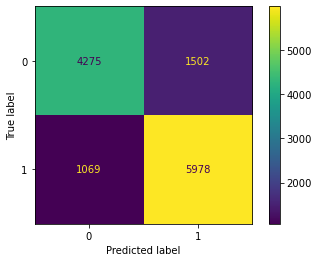

In [34]:
knn_better = KNeighborsClassifier(14, metric = "manhattan", weights = 'distance') 
knn_better.fit(X_train_clean, y_train)

score_maxtrix_printer(knn_better, X_train_clean, y_train, X_test_clean, y_test)

While our kNN model overfit on our training data, our testing data metrics were the best so far  us our best testing results so far, with an accuracy score and a precison score of 80%.

---
## Final Model with an Ensemble

Although our Knn model produced the best precision and accuracy scores it was clearly overfitting our training data. Because of this we decided to utilize an aggregation method by creating an Ensemble of our previous models. This would give us the ability to control how much significance or weight, we would like to put on the models to produce the best aggregate score.<br>
<br>
We decided to use `VotingClassifier()` to combine our models together to get optimal performance. We chose to give our optimized kNN model the most weight (50%), as it performed the best in both accuracy and precision on testing data. We split the remaining weight percentage equally between our optimized decision tree model and logistic regression model (25% each).

In [35]:
avg = VotingClassifier(estimators=[ ('lr', logreg_model),
                                    ('dt', decision_tree_better),
                                    ('knn', knn_better)],
                                     weights = [0.25, 0.25, 0.5])
avg.fit(X_train_clean, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=69)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=25,
                                                     min_samples_leaf=7,
                                                     random_state=69)),
                             ('knn',
                              KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=14,
                                                   weights='distance'))],
                 weights=[0.25, 0.25, 0.5])


    Ensemble CV Score: 0.8042630621263323
    Final Test Accuracy: 0.8018558951965066
    Final Test Precision: 0.8198466780238501



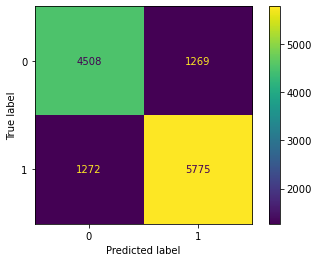

In [36]:
#This block may take a minute because it is run on the ensemble
scores = cross_val_score(estimator = avg, X = X_train_clean, y = y_train, cv = 5)

print(f"""
    Ensemble CV Score: {np.median(scores)}
    Final Test Accuracy: {accuracy_score(y_test, avg.predict(X_test_clean))}
    Final Test Precision: {precision_score(y_test, avg.predict(X_test_clean))}
""")
plot_confusion_matrix(avg, X_test_clean, y_test);

Our ensemble model outperformed our earlier models. 
#### On our testing set we achieved a fantastic 81% accuracy score and 82% precision score!

---

Taking a look at our TPR (True Positive Ratio) and FPR (False Positive Ratio) we can see that our model is very good at properly identifying true positives while have a good false positive rate as well.

In [37]:
cm = confusion_matrix(y_test, avg.predict(X_test_clean))

tp, tn, fp, fn = cm[1][1], cm[0][0], cm[0][1], cm[1][0]
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

print(f"""
    True Positive Rate: {tpr}
    False Positive Rate: {fpr}
""")


    True Positive Rate: 0.8194976585781183
    False Positive Rate: 0.21966418556344122



# 5. Evaluation
---
To further reinforce why have a high precision in order to correctly identify a functioning well from a non-functioning well. A False positive would mean that we are identifying a non-functional well as functional. This would not only waste resources by sending maintenance to already functional wells, but this would also mean that populations without a functional well will be further delayed in receiving aid. <br>
<br>
To finalize our modeling we ended with an accuracy of 81% and a precision of 82% after the Ensembling.
Thusfar we have found that elevation and location are the most important factors that contribute to a wells functionality. This is shown in more detail by the map visualizations we conducted at the end.

---
## Data Cleaning on the True Test Data

Below we prepared the data of the true test set exactly the same way as we did when prepairing the training data set eariler. Due to this being the true testing data, there were no target values provided to compare our final predictions with (meaning we were unable to calculate our accuracy and precision scores).

In [38]:
df3 = data_cleaning(df_test)
Ftest = split_join(df3)
df3['targets'] = avg.predict(Ftest)

Now that we have prepared our test data, we use our ensemble model 'avg' to predict the target for the `Ftest` DataFrame and add it to the DataFrame as a new column,`targets`

---
## Mapping Our Test Data Results

Now that we have used our model to predict the functioning status of our wells, we can plot it on a map of Tanzania to see which regions are in most need of aid. Red dots identify the wells that require repair while blue dots proclaim that well as functioning. 
* This code has been commented out due to errors that occur if geopandas and contextily are not properly installed. An image of the resulting graph has been posted.

In [39]:
drop_zeros = df3.loc[(df3['longitude'] != 0.0) & (df3['latitude'] != 0.0)]

fig, ax = plt.subplots(figsize=(18,12))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

drop_zeros
sns.scatterplot(x = drop_zeros['longitude'], y = drop_zeros['latitude'], hue = drop_zeros["targets"], \
                palette = ["red", "blue"], alpha = .5)

ax.grid(b=True, alpha=0.5)

cx.add_basemap(ax, crs=countries.crs.to_string())

ax.set(title='Combined Wells, 0 = Broken, 1 = Working')
plt.legend(title='Wells', loc='upper right', labels=['Need Repair', 'Working'])

plt.show()

# fig.savefig("combo.png") # Saving the resulting map as a .png file

![Combined Map](images/combo.png)


From this figure it can be seen that inland, on the southern Tanzanian boarder, there are many wells in need of repair. You can also see few functioning wells in this same area meaning these communities will have to travel farther to get access to drinking water. Regions like these definitely should be focused on when considering where to immediately begin aid.

---
# 6. Appendix
---

### Wells in need of repair, plotted in red. 
* This code has been commented out due to errors that occur if geopandas and contextily are not properly installed. An image of the resulting graph has been posted.

In [40]:
temp_0 = df3.loc[(df3['longitude'] != 0.0) & (df3['latitude'] != 0.0)]


temp_00 = temp_0.loc[(df3['targets'] == 0)]

dropper = temp_00

fig, ax = plt.subplots(figsize=(18,12))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

sns.scatterplot(x = dropper['longitude'], y = dropper['latitude'], color = "red", alpha = .5)

ax.grid(b=True, alpha=0.5)

cx.add_basemap(ax, crs=countries.crs.to_string())
ax.set(title='Need Repair')


plt.show()
# fig.savefig("need_repair.png") # Saving the resulting map as a .png file



![Wells Needing Repair Map](images/need_repair.png)

### Wells that are fully functional, plotted in blue. 
* This code has been commented out due to errors that occur if geopandas and contextily are not properly installed. An image of the resulting graph has been posted.

In [41]:
temp_1 = df3.loc[(df3['longitude'] != 0.0) & (df3['latitude'] != 0.0)]


temp_11 = temp_1.loc[(df3['targets'] == 1)]

dropper_1 = temp_11

fig, ax = plt.subplots(figsize=(18,12))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


sns.scatterplot(x = dropper_1['longitude'], y = dropper_1['latitude'], color = "blue", alpha = .5)

ax.grid(b=True, alpha=0.5)

cx.add_basemap(ax, crs=countries.crs.to_string())

ax.set(title='Functioning Wells')

plt.show()

 
# fig.savefig("working.png") # Saving the resulting map as a .png file

![Functioning Well Map](images/working.png)
